# Preprocessing

In [37]:
import datetime
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, Model, backend as K

from functools import partial
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('drive/MyDrive/TravelHack_Foundation/travelhack6.csv')
print(df.columns)
df.head()

Index(['Пол', 'День рождения', 'Возраст клиента', 'Заявка № ',
       'Дата бронирования', 'Дата начала тура', 'Год', 'Ночей', 'Вид тура',
       'Тип заявки', 'Страна тура', 'Регион отеля', 'Туристов',
       'Туристы, взрослые', 'Туристы, дети', 'Младенцы', 'Звездность',
       'Состав группы (Заявка) (Заявка)', 'Сумма в $', 'Наименование тура',
       'ИД клиента', 'Глубина продаж', 'Тип питания', 'Город Отеля',
       'Город отправления'],
      dtype='object')


,Пол,День рождения,Возраст клиента,Заявка №,Дата бронирования,Дата начала тура,Год,Ночей,Вид тура,Тип заявки,Страна тура,Регион отеля,Туристов,"Туристы, взрослые","Туристы, дети",Младенцы,Звездность,Состав группы (Заявка) (Заявка),Сумма в $,Наименование тура,ИД клиента,Глубина продаж,Тип питания,Город Отеля,Город отправления
0,мужской,2018-08-28 00:00:00,2.0,4803671,2021-02-07 20:44:00,2021-05-04 00:00:00,2021,12,Пляжный отдых,Пакет,Турция,NaN,4,2,2,0,4*,Семья,1718.64,Turkey Antalya LED,4197428,85.136111,All Inclusive,NaN,Санкт-Петербург
1,мужской,1991-04-25 00:00:00,29.0,4803671,2021-02-07 20:44:00,2021-05-04 00:00:00,2021,12,Пляжный отдых,Пакет,Турция,NaN,4,2,2,0,4*,Семья,1718.64,Turkey Antalya LED,4197429,85.136111,All Inclusive,NaN,Санкт-Петербург
2,мужской,1980-11-05 00:00:00,40.0,4803915,2021-02-08 09:03:00,2021-03-04 00:00:00,2021,6,Пляжный отдых,Пакет,Турция,Белек,3,2,1,0,5*,Семья,948.45,Turkey Antalya MOW,4197517,23.622917,AIP,Боазкент,Москва
3,мужской,2013-02-27 00:00:00,8.0,4806034,2021-02-08 19:46:00,2021-10-09 00:00:00,2021,11,Пляжный отдых,Пакет,Турция,Кемер,3,2,1,0,5*,Семья,2128.15,Turkey Antalya MOW,4197718,242.176389,UAI,Текирова,Москва
4,мужской,1968-10-06 00:00:00,52.0,4806034,2021-02-08 19:46:00,2021-10-09 00:00:00,2021,11,Пляжный отдых,Пакет,Турция,Кемер,3,2,1,0,5*,Семья,2128.15,Turkey Antalya MOW,4197719,242.176389,UAI,Текирова,Москва


In [3]:
for c in ['День рождения', 'Дата бронирования', 'Дата начала тура']:
    df[c] = pd.to_datetime(df[c], format='%Y-%m-%d %H:%M:%S')
df[['День рождения', 'Дата бронирования', 'Дата начала тура']].head()

,День рождения,Дата бронирования,Дата начала тура
0,2018-08-28,2021-02-07 20:44:00,2021-05-04
1,1991-04-25,2021-02-07 20:44:00,2021-05-04
2,1980-11-05,2021-02-08 09:03:00,2021-03-04
3,2013-02-27,2021-02-08 19:46:00,2021-10-09
4,1968-10-06,2021-02-08 19:46:00,2021-10-09


In [4]:
star_map = {
    '5*': 5,
    '4*': 4,
    '3*': 3,
    '2*': 2,
    '-': np.nan,
    '4*+': 4,
    '3*+': 3,
    'apt': 'apt',
    '0': np.nan,
    'HV1': 'HV',
    'Без звёзд': np.nan,
    'HV': 'HV',
    'HV2': 'HV',
    '3*-4*': 3,
    'BOUTIQUE': np.nan,
    '1*': 1,
    '2*super': 2,
    '2*+': 2,
    'Guest House': 'apt',
    'Std Apt': 'apt',
    '5*+': 5,
    '2*-3*': 2,
    '5* Deluxe': 5,
    '4*-5*': 4,
    'S-CLASS': np.nan,
    '3*super': 3,
    'SC': 'apt',
    'cat A': 4,
    'cat B': 3,
}

df['Звездность_fix'] = df['Звездность'].map(star_map)
df['Звездность_fix'].value_counts()

5      61344
4      27659
3      16269
2       1574
HV       764
apt      516
1         71
Name: Звездность_fix, dtype: int64

In [5]:
foods = df['Тип питания'].unique()
food_map = {
    'UAI': [
        'UAI', 'Ultra All Exclusive', 'All Inclusive Ultra', 'ULTRA ALL INCLUSIVE PLUS', 'Ultimate All Inclusive',
        'PREMIER ULTRA ALL INCLUSIVE', 'PREMIUM ALA CARTE ALL INCLUSIVE', 'Golden All Inclusive',
        'Platinum Plan All inclusive', 'SUPERIOR ALL INCLUSIVE', 'All Inclusive Premium',
        'ULTRA ALL INCLUSIVE WITH HIGH LEVEL', 'Emerald All Inclusive', 'Gold All Inclusive',
        'Super All Inclusive', 'All Inc Ultra Luxury', 'Diamond AI', 'PREMIUM ULTRA ALL INCLUSIVE',
        'AIP', 'AIS', 'Crystal Package',  'PRIVILEGED LIFE', 'Pure Indulgence Dine Around', 'Serenity Plan',
        'PRE.AI.LIFE STYLE', 'Premium All Inclusive', 'PALAZZO ALL INCLUSIVE'
    ],
    'AI': [
        'AI', 'All Inclusive', 'All Inclusive Dine Around',
        'Basic All Inclusive', 'Soft All Inclusive', "A'LA CARTE ALL INCLUSIVE", 'Light All Inclusive', 
        'All Inclusive Aqua', 'Limited all Inclusive', 'Island Plan All Inclusive',
        'Full Dine Around All Inclusive', 'VARU ALL INCLUSIVE', 'All inclusive Style',
        'All Inclusive Lite',  'Все включено СЕМЕЙНЫЙ', 'Все включено ПЛЯЖНЫЙ',
        'AI Light', 'AI NON ALCOHOL', 'ALL IN CONCEPT', 
        'LAI', 'LAI HB', 'FAI','DAI', 'DDAI', 'EAI', 'HB AI', 'FB AI', 'LAI FB', 'MAI'
    ],
    'FB': [
        'FB', 'BB+FB', 'FB + Оздоровит. путевка', 'FB+',  'FB + Лечение',
        'FB Beverage', 'FB + Общетерапевт.путевка',
        'FB + Антистресс', 'FB + Оздоровительная', 'FB + Отдых', 'FBT',
        'FB ресторан «Алтай» + Лечебная путевка', 'FB + Gala Dinner',
        'Полный пансион', 'Полный пансион + Лечение', 'Полный Пансион (шведский стол) + Отдых',
        'Полный Пансион+Отдых бассейн с термотерапией', 'Полный пансион+ Общетерапевтическая Лайт',
        'Полный пансион + Общетерапевтическая с Мацестой', 'Полный пансион + Общетерапевтическая без Мацесты',
        'Полный пансион + путевка Курортная', 'Полный Пансион + Смарт путевка', 'Полный Пансион + Серебряный возраст',
        'Full Board + drinks', 'Full Board Premium', 'Full Board Treatment Relax', 'Оздоровительная.',
        'FBp - Завтрак, обед, ужин (Premium)'
    ],
    'HB': [
        'HB', 'HB (завтрак+ужин)', 'HB + Оздоровит. путевка', 'HB+', 'HB Plus',
        'HB (завтрак+обед)', 'HB Beverage', 'BB+HB', 'HBT', 'HB + Лечение',
        'PR - Завтрак, ужин (Premium)',
        'Полупансион (завтрак+ужин)', 'Half Board Platinum', 'Half board + drinks',
        'Half Board Dine Around', 'Half Board Premium', 'Half Board Beach', 'Half Board Treatment Relax'
    ],
    'BB': [
        'Завтрак', 'BB', 'BB Continental', 'BB + Оздоровит. путевка', 'BB Пляжный',
        'Breakfast', 'Bed And Breakfast Plus'
    ],
    'RO': [
        'RO', 'RO + Оздоровительная курсовка', 'RO + Оздоровительная путевка', 'Only Bed', 'Bed Only', 'Без питания'
    ]
}
t = [vv for v in food_map.values() for vv in v]
print(len(t) == len(set(t)))
set(foods) - set([vv for v in food_map.values() for vv in v])

True


{'0',
 'AXI',
 'Al + лечение',
 'As Per Program',
 'HCI',
 'HEA',
 'LUXME',
 'SC',
 nan,
 'По программе',
 'По программе +'}

In [6]:
def fix_food(f):
    for key in food_map:
        if f in food_map[key]:
            return key
df['Тип питания fix'] = df['Тип питания'].apply(fix_food)
df['Тип питания fix'].value_counts()

AI     44930
UAI    30551
HB     12459
BB     11874
FB      3336
RO      2362
Name: Тип питания fix, dtype: int64

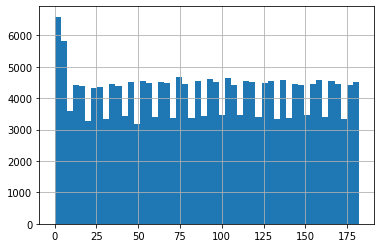

In [10]:
def time_diff(row):
    d1 = row['День рождения'].dayofyear
    d2 = row['Дата начала тура'].dayofyear
    if d1>d2: d2,d1=d1,d2
    return d2-d1 if d2-d1<183 else d1+365-d2
df['Начало тура ДР'] = df.apply(time_diff, axis=1)
df['Начало тура ДР'].hist(bins=50);

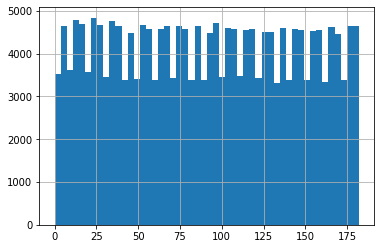

In [11]:
def time_diff(row):
    d1 = row['День рождения'].dayofyear
    d2 = row['Дата бронирования'].dayofyear
    if d1>d2: d2,d1=d1,d2
    return d2-d1 if d2-d1<183 else d1+365-d2
df['Бронь ДР'] = df.apply(time_diff, axis=1)
df['Бронь ДР'].hist(bins=50);

In [12]:
df = df.rename(columns={
    'Состав группы (Заявка) (Заявка)': 'Состав группы',
    'Заявка № ': 'Заявка',
    'Сумма в $': 'Сумма',
    'Город Отеля': 'Город отеля'
})

In [13]:
df['Месяц Бронирования'] = df['Дата бронирования'].apply(lambda x: x.month)
df['Месяц Выезда'] = df['Дата бронирования'].apply(lambda x: x.month)

In [14]:
df.loc[df['Возраст клиента']>100, 'День рождения'] = np.nan
df.loc[df['Возраст клиента']>100, 'Возраст клиента'] = np.nan

df['День рождения'].fillna(df['Дата бронирования'] -  datetime.timedelta(30*360), inplace=True)
df['Возраст клиента'].fillna(30, inplace=True)

In [15]:
f = [
    'ИД клиента',
    'Пол',
    'Возраст клиента',
    'Начало тура ДР',
    'Месяц Бронирования',
    'Месяц Выезда',
    'Туристов',
    'Туристы, взрослые',
    'Туристы, дети',
    'Младенцы',
    'Состав группы',
    'Город отправления'
]

t = [
    'Ночей',
    'Сумма',
    'Звездность_fix',
    'Тип питания fix',
    'Страна тура',
    'Регион отеля',
    'Город отеля',
]

In [18]:
df['Пол'] = (df['Пол']=='мужской').astype(int)
df['Пол'].value_counts()

0    124300
1     85309
Name: Пол, dtype: int64

# Enconding & Normalizing

In [16]:
enc = {}
for tt in t[2:]:
    l = df[tt].astype(str).unique().tolist()
    l = [x for x in l if x!='nan']
    l.insert(0, 'nan')
    enc[tt] = l
    df[tt + '_enc'] = df[tt].astype(str).apply(lambda x: l.index(x))

In [17]:
for tt in ['ИД клиента', 'Состав группы', 'Город отправления']:
    l = df[tt].unique().tolist()
    enc[tt] = l
    df[tt + '_enc'] = df[tt].apply(lambda x: l.index(x))

In [21]:
f_enc = [
    'ИД клиента_enc',
    'Пол',
    'Возраст клиента',
    'Начало тура ДР',
    'Месяц Бронирования',
    'Месяц Выезда',
    'Туристов',
    'Туристы, взрослые',
    'Туристы, дети',
    'Младенцы',
    'Состав группы_enc',
    'Город отправления_enc'
]

t_enc = [
    'Ночей',
    'Сумма',
    'Звездность_fix_enc',
    'Тип питания fix_enc',
    'Страна тура_enc',
    'Регион отеля_enc',
    'Город отеля_enc',
]

In [22]:
norm = {}
for feature in f_enc + t_enc:
    if not '_enc' in feature:
        norm[feature] = {'mean': df[feature].mean(), 'std': df[feature].std()}
        df[feature+'_norm'] = (df[feature] - norm[feature]['mean'])/norm[feature]['std']

In [23]:
f_enc_norm = [
    'ИД клиента_enc',
    'Пол',
    'Возраст клиента_norm',
    'Начало тура ДР_norm',
    'Месяц Бронирования_norm',
    'Месяц Выезда_norm',
    'Туристов_norm',
    'Туристы, взрослые_norm',
    'Туристы, дети_norm',
    'Младенцы_norm',
    'Состав группы_enc',
    'Город отправления_enc'
]

t_enc_norm = [
    'Ночей_norm',
    'Сумма_norm',
    'Звездность_fix_enc',
    'Тип питания fix_enc',
    'Страна тура_enc',
    'Регион отеля_enc',
    'Город отеля_enc'
]

In [25]:
df[f_enc_norm + t_enc_norm].to_csv('travelhack_preproc.csv', index=False)

In [26]:
!cp travelhack_preproc.csv /content/drive/MyDrive/TravelHack_Foundation/

In [32]:
import json
with open('norm.json', 'w') as f:
    json.dump(norm, f)

with open('enc.json', 'w') as f:
    json.dump(enc, f)

In [33]:
!cp norm.json /content/drive/MyDrive/TravelHack_Foundation/
!cp enc.json /content/drive/MyDrive/TravelHack_Foundation/

In [34]:
q = df.groupby('ИД клиента').size()
multi_client = q[q>1].index
test_index = df[df['ИД клиента'].isin(multi_client)].sample(frac=1).drop_duplicates('ИД клиента').index

In [35]:
x_train, y_train = df.loc[~df.index.isin(test_index), f_enc_norm].values, df.loc[~df.index.isin(test_index), t_enc_norm].values
x_test, y_test = df.loc[test_index, f_enc_norm].values, df.loc[test_index, t_enc_norm].values
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((195826, 12), (195826, 7), (13783, 12), (13783, 7))

In [248]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(2048)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(2048)

# Model definition

In [186]:
enc.keys()

dict_keys(['Звездность_fix', 'Тип питания fix', 'Страна тура', 'Регион отеля', 'Город отеля', 'ИД клиента', 'Состав группы', 'Город отправления'])

In [188]:
enc['Звездность_fix']

['nan', '4', '5', '3', 'HV', '2', 'apt', '1']

In [201]:
inp_client = layers.Input(shape=(1,))
emb_client = layers.Embedding(193276, 64)(inp_client)
emb_client = layers.Flatten()(emb_client)

inp_num = layers.Input(shape=(9,))


inp_sostav = layers.Input(shape=(1,))
emb_sostav = layers.Embedding(5, 5)(inp_sostav)
emb_sostav = layers.Flatten()(emb_sostav)

inp_gorod = layers.Input(shape=(1,))
emb_gorod = layers.Embedding(227, 5)(inp_gorod)
emb_gorod = layers.Flatten()(emb_gorod)

l = layers.Concatenate()([emb_client, emb_gorod, emb_sostav, inp_num])
l = layers.Dense(256, activation='relu')(l)
l = layers.Dense(256, activation='relu')(l)

out_all = layers.Dense(2)(l)
out_zvezd = layers.Dense(len(enc['Звездность_fix']))(l)
out_pit = layers.Dense(len(enc['Тип питания fix']))(l)
out_strana = layers.Dense(len(enc['Страна тура']))(l)
out_region = layers.Dense(len(enc['Регион отеля']))(l)
out_gorod = layers.Dense(len(enc['Город отеля']))(l)


model_all = Model([inp_client, inp_num, inp_sostav, inp_gorod], out_all)
model_zvezd = Model([inp_client, inp_num, inp_sostav, inp_gorod], out_zvezd)
model_pit = Model([inp_client, inp_num, inp_sostav, inp_gorod], out_pit)
model_strana = Model([inp_client, inp_num, inp_sostav, inp_gorod], out_strana)
model_region = Model([inp_client, inp_num, inp_sostav, inp_gorod], out_region)
model_gorod = Model([inp_client, inp_num, inp_sostav, inp_gorod], out_gorod)


model_all.summary()
model_zvezd.summary()
model_pit.summary()
model_strana.summary()
model_region.summary()
model_gorod.summary()

Model: "model_36"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_27 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 1, 64)        12369664    input_25[0][0]                   
___________________________________________________________________________________________

In [77]:
a, b = tf.Variable([0.,1.,2.,2.,3.,0.,5.]), tf.Variable([1.,1.,2.,2.,3.,1.,5.])

In [78]:
b.shape, a.shape, (a*tf.cast(b>0, tf.float32)).shape

(TensorShape([7]), TensorShape([7]), TensorShape([7]))

In [79]:
K.categorical_crossentropy(b, a*tf.cast(b>0, tf.float32))

<tf.Tensor: shape=(), dtype=float32, numpy=51.46492>

In [68]:
nan_sparse_ce(tf.Variable([0.,1.,2.,2.,3.,0.,5.]), tf.Variable([1.,1.,2.,2.,3.,1.,5.]))

ValueError: ignored

In [202]:
def nan_sparse_ce(y_true, y_pred):
    return K.sparse_categorical_crossentropy(y_true, y_pred*tf.cast(y_true>0, tf.float32), from_logits=True)


In [203]:
from collections import namedtuple
HackModel = namedtuple('model', ['name', 'model', 'tar_idx', 'opt', 'loss', 'metric'])

models = [
    HackModel('model_all', model_all, [0,1], keras.optimizers.Adam(), keras.losses.MeanSquaredError(), keras.metrics.MeanSquaredError()),
    HackModel('model_zvezd', model_zvezd, [2], keras.optimizers.Adam(), nan_sparse_ce, keras.metrics.SparseCategoricalAccuracy()),
    HackModel('model_pit', model_pit, [3], keras.optimizers.Adam(), nan_sparse_ce, keras.metrics.SparseCategoricalAccuracy()),
    HackModel('model_strana', model_strana, [4], keras.optimizers.Adam(), nan_sparse_ce, keras.metrics.SparseCategoricalAccuracy()),
    HackModel('model_region', model_region, [5], keras.optimizers.Adam(), nan_sparse_ce, keras.metrics.SparseCategoricalAccuracy()),
    HackModel('model_gorod', model_gorod, [6], keras.optimizers.Adam(), nan_sparse_ce, keras.metrics.SparseCategoricalAccuracy()),
]

# Training

In [204]:
# @tf.function
def train_step(x, y, model):
    with tf.GradientTape() as tape:
        out = model.model(x, training=True)
        loss_value = model.loss(y, out)
    grads = tape.gradient(loss_value, model.model.trainable_weights)
    model.opt.apply_gradients(zip(grads, model.model.trainable_weights))
    return loss_value


@tf.function
def test_step(x, y, model):
    logits = model.model(x, training=False)
    model.metric.update_state(y, logits)


In [249]:
def tf_train(epochs, history=None, plot_every=None, progress=True):
#     history = history or {
#         'train_accs': [],
#         'train_losses': [],
#         'test_accs': [],
#         'test_losses': [],
#     }
    tqdm_ = partial(tqdm,
                disable=not progress, # не показывать бар вообще
                leave=False) # убрать бар после окончания
    
    for epoch in range(epochs):
        print(f'epoch {epoch}')
        for model in models:
            for batch, (x_train_batch, y_train_batch) in enumerate(tqdm_(train_dataset, desc=f'train {model.name}')):
                # print(model)
                x_train_batch = [tf.gather(x_train_batch, inp, axis=1) for inp in [[0], list(range(1,10)), [10], [11]]]
                y_train_batch = tf.gather(y_train_batch, model.tar_idx, axis=1)
                # print(y_train_batch.shape)
                train_step(x_train_batch, y_train_batch, model)

        train_losses = {}
        for model in models:
            train_losses[model.name] = []
            for batch, (x_train_batch, y_train_batch) in enumerate(tqdm_(train_dataset, desc=f'eval {model.name}')):
                x_train_batch = [tf.gather(x_train_batch, inp, axis=1) for inp in [[0], list(range(1,10)), [10], [11]]]
                y_train_batch = tf.gather(y_train_batch, model.tar_idx, axis=1)
                test_step(x_train_batch, y_train_batch, model)
                train_losses[model.name].append(model.metric.result())
                model.metric.reset_states()

        test_losses = {}
        for model in models:
            test_losses[model.name] = []
            for batch, (x_test_batch, y_test_batch) in enumerate(tqdm_(test_dataset, desc=f'eval {model.name}')):
                breakpoint()
                x_test_batch = [tf.gather(x_test_batch, inp, axis=1) for inp in [[0], list(range(1,10)), [10], [11]]]
                y_test_batch = tf.gather(y_test_batch, model.tar_idx, axis=1)
                test_step(x_test_batch, y_test_batch, model)
                test_losses[model.name].append(model.metric.result())
                model.metric.reset_states()
        
        for model in models:
            print(f'model {model.name}\n'
                  f'train: {np.mean(train_losses[model.name])}\n'
                  f'test:  {np.mean(test_losses[model.name])}')
        
#         if plot_every and epoch % plot_every == 0:
#             plot_history(history)
#         else:
            print()
    
    # not to plot double
#     if not plot_every or epoch % plot_every > 0:
#         plot_history(history)

    return history

In [250]:
tf_train(epochs=10)

epoch 0


model model_all
train: 0.9668553471565247
test:  1.5543769598007202

model model_zvezd
train: 0.13573850691318512
test:  0.08177929371595383

model model_pit
train: 0.4846438467502594
test:  0.6428252458572388

model model_strana
train: 0.5947269201278687
test:  0.6143671870231628

model model_region
train: 0.05464189127087593
test:  0.036872535943984985

model model_gorod
train: 0.010380018502473831
test:  0.004391685128211975

epoch 1


model model_all
train: 0.9658963680267334
test:  1.5578529834747314

model model_zvezd
train: 0.29769375920295715
test:  0.2365516573190689

model model_pit
train: 0.4846438467502594
test:  0.6428252458572388

model model_strana
train: 0.5947269201278687
test:  0.6143671870231628

model model_region
train: 0.05464189127087593
test:  0.036872535943984985

model model_gorod
train: 0.010380018502473831
test:  0.004391685128211975

epoch 2


model model_all
train: 0.9655014872550964
test:  1.560351014137268

model model_zvezd
train: 0.29769375920295715
test:  0.2365516573190689

model model_pit
train: 0.4846438467502594
test:  0.6428252458572388

model model_strana
train: 0.5947269201278687
test:  0.6143671870231628

model model_region
train: 0.05464189127087593
test:  0.036872535943984985

model model_gorod
train: 0.010380018502473831
test:  0.004391685128211975

epoch 3


model model_all
train: 0.9653425216674805
test:  1.5620619058609009

model model_zvezd
train: 0.29769375920295715
test:  0.2365516573190689

model model_pit
train: 0.4846438467502594
test:  0.6428252458572388

model model_strana
train: 0.5947269201278687
test:  0.6143671870231628

model model_region
train: 0.05464189127087593
test:  0.036872535943984985

model model_gorod
train: 0.010380018502473831
test:  0.004391685128211975

epoch 4


KeyboardInterrupt: ignored

In [247]:
tf_train(epochs=1)

epoch 0


KeyboardInterrupt: ignored

In [229]:
enc.keys()

dict_keys(['Звездность_fix', 'Тип питания fix', 'Страна тура', 'Регион отеля', 'Город отеля', 'ИД клиента', 'Состав группы', 'Город отправления'])

In [233]:
models[3]

model(name='model_strana', model=<tensorflow.python.keras.engine.functional.Functional object at 0x7fb8a00d1d90>, tar_idx=[4], opt=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fb8cf6a77d0>, loss=<function nan_sparse_ce at 0x7fb81fc4f050>, metric=<tensorflow.python.keras.metrics.SparseCategoricalAccuracy object at 0x7fb84a1a9590>)

In [258]:
(enc['Город отеля'][35])

'Конаклы'

In [259]:
preds = []
for batch, (x_train_batch, y_train_batch) in enumerate(tqdm(train_dataset, desc=f'eval {model.name}')):
    x_train_batch = [tf.gather(x_train_batch, inp, axis=1) for inp in [[0], list(range(1,10)), [10], [11]]]
    y_train_batch = tf.gather(y_train_batch, model.tar_idx, axis=1)
    preds.append(models[0].model.predict(x_train_batch))



In [265]:
np.concatenate(preds)[:,1]

array([-0.00388356, -0.00388356, -0.00388356, ..., -0.00388356,
       -0.00388356, -0.00388356], dtype=float32)

(array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0., 195826.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.]),
 array([-0.50934464, -0.4760113 , -0.44267797, -0.40934464, -0.3760113 ,
        -0.34267798, -0.30934465, -0.27601132, -0.24267797, -0.20934464,
        -0.17601131, -0.14267798, -0.10934465, -0.07601131, -0.04267798,
        -0.00934464,  0.02398869,  0.05732202,  0.09065536,  0.12398869,
         0.15732202,  0.19065535,  0.22398868,  0.257322  ,  0.29065534,
         0.32398868,  0.357322  ,  0.39065537,  0.4239887 ,  0.45732203,
         0.49065536], dtype=float32),
 <a list of 30 Patch objects>)

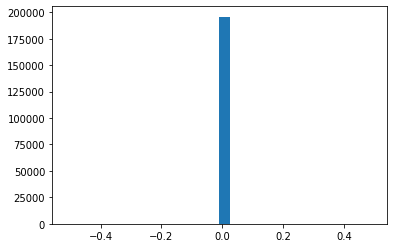

In [263]:
plt.hist(np.concatenate(preds)[:,0], bins=30)

In [223]:
np.concatenate(preds)

array([[-0.17231867,  0.17373857,  0.15627335, ..., -0.16845562,
        -0.17082335, -0.1722486 ],
       [-0.17231867,  0.17373857,  0.15627335, ..., -0.16845562,
        -0.17082335, -0.1722486 ],
       [-0.17231867,  0.17373857,  0.15627335, ..., -0.16845562,
        -0.17082335, -0.1722486 ],
       ...,
       [-0.17231867,  0.17373857,  0.15627335, ..., -0.16845562,
        -0.17082335, -0.1722486 ],
       [-0.17231867,  0.17373857,  0.15627335, ..., -0.16845562,
        -0.17082335, -0.1722486 ],
       [-0.17231867,  0.17373857,  0.15627335, ..., -0.16845562,
        -0.17082335, -0.1722486 ]], dtype=float32)

# Recommendation boosting

In [270]:
df[['Заявка'] + f_enc_norm + t_enc_norm].head()

,Заявка,ИД клиента_enc,Пол,Возраст клиента_norm,Начало тура ДР_norm,Месяц Бронирования_norm,Месяц Выезда_norm,Туристов_norm,"Туристы, взрослые_norm","Туристы, дети_norm",Младенцы_norm,Состав группы_enc,Город отправления_enc,Ночей_norm,Сумма_norm,Звездность_fix_enc,Тип питания fix_enc,Страна тура_enc,Регион отеля_enc,Город отеля_enc
0,4803671,0,1,-1.741163,0.491109,-1.249983,-1.249983,0.911779,-0.059509,1.647407,-0.292106,0,0,0.752632,-0.213534,1,1,1,0,0
1,4803671,1,1,-0.282634,-1.510667,-1.249983,-1.249983,0.911779,-0.059509,1.647407,-0.292106,0,0,0.752632,-0.213534,1,1,1,0,0
2,4803915,2,1,0.311582,0.528526,-1.249983,-1.249983,0.141354,-0.059509,0.396827,-0.292106,0,1,-0.880616,-0.654687,2,2,1,1,1
3,4806034,3,1,-1.417045,0.958814,-1.249983,-1.249983,0.141354,-0.059509,0.396827,-0.292106,0,1,0.480424,0.021028,2,2,1,2,2
4,4806034,4,1,0.959817,-1.641624,-1.249983,-1.249983,0.141354,-0.059509,0.396827,-0.292106,0,1,0.480424,0.021028,2,2,1,2,2


In [271]:
df.columns

Index(['Пол', 'День рождения', 'Возраст клиента', 'Заявка',
       'Дата бронирования', 'Дата начала тура', 'Год', 'Ночей', 'Вид тура',
       'Тип заявки', 'Страна тура', 'Регион отеля', 'Туристов',
       'Туристы, взрослые', 'Туристы, дети', 'Младенцы', 'Звездность',
       'Состав группы', 'Сумма', 'Наименование тура', 'ИД клиента',
       'Глубина продаж', 'Тип питания', 'Город отеля', 'Город отправления',
       'Звездность_fix', 'Тип питания fix', 'Начало тура ДР', 'Бронь ДР',
       'Месяц Бронирования', 'Месяц Выезда', 'Звездность_fix_enc',
       'Тип питания fix_enc', 'Страна тура_enc', 'Регион отеля_enc',
       'Город отеля_enc', 'ИД клиента_enc', 'Состав группы_enc',
       'Город отправления_enc', 'Пол_norm', 'Возраст клиента_norm',
       'Начало тура ДР_norm', 'Месяц Бронирования_norm', 'Месяц Выезда_norm',
       'Туристов_norm', 'Туристы, взрослые_norm', 'Туристы, дети_norm',
       'Младенцы_norm', 'Ночей_norm', 'Сумма_norm'],
      dtype='object')

In [274]:
def agg_client(dfc):
    dfc = dfc.sort_values('Дата бронирования')
    return dfc[f_enc_norm + t_enc_norm].iloc[0]
dfc = df.groupby('ИД клиента_enc').apply(agg_client)
dfc.head()

,ИД клиента_enc,Пол,Возраст клиента_norm,Начало тура ДР_norm,Месяц Бронирования_norm,Месяц Выезда_norm,Туристов_norm,"Туристы, взрослые_norm","Туристы, дети_norm",Младенцы_norm,Состав группы_enc,Город отправления_enc,Ночей_norm,Сумма_norm,Звездность_fix_enc,Тип питания fix_enc,Страна тура_enc,Регион отеля_enc,Город отеля_enc
ИД клиента_enc,,,,,,,,,,,,,,,,,,,
0,0.0,1.0,-1.741163,0.491109,-1.249983,-1.249983,0.911779,-0.059509,1.647407,-0.292106,0.0,0.0,0.752632,-0.213534,1.0,1.0,1.0,0.0,0.0
1,1.0,1.0,-0.282634,-1.510667,-1.249983,-1.249983,0.911779,-0.059509,1.647407,-0.292106,0.0,0.0,0.752632,-0.213534,1.0,1.0,1.0,0.0,0.0
2,2.0,1.0,0.311582,0.528526,-1.249983,-1.249983,0.141354,-0.059509,0.396827,-0.292106,0.0,1.0,-0.880616,-0.654687,2.0,2.0,1.0,1.0,1.0
3,3.0,1.0,-1.417045,0.958814,-1.249983,-1.249983,0.141354,-0.059509,0.396827,-0.292106,0.0,1.0,0.480424,0.021028,2.0,2.0,1.0,2.0,2.0
4,4.0,1.0,0.959817,-1.641624,-1.249983,-1.249983,0.141354,-0.059509,0.396827,-0.292106,0.0,1.0,0.480424,0.021028,2.0,2.0,1.0,2.0,2.0


In [275]:
first_tour = df.sort_values('Дата бронирования').groupby('ИД клиента').first()

In [278]:
first_tour.shape

(193276, 49)

In [277]:
not_first_tour = df[~df['Заявка'].isin(first_tour['Заявка'])]
not_first_tour.shape

(12050, 50)

In [279]:
f =  [
    # 'ИД клиента_enc',
    'Пол',
    'Возраст клиента_norm',
    'Начало тура ДР_norm',
    'Месяц Бронирования_norm',
    'Месяц Выезда_norm',
    'Туристов_norm',
    'Туристы, взрослые_norm',
    'Туристы, дети_norm',
    'Младенцы_norm',
    'Состав группы',
    'Город отправления'
]

<_io.TextIOWrapper name='enc.json' mode='w' encoding='UTF-8'>

In [ ]:
not_first_tour['']